In [2]:
import os
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

import mediapipe as mp
import cv2

import joblib

C:\Users\mbaff\AppData\Local\Temp\ipykernel_16052\1581626725.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
main_directory = './ressources/asl_alphabet_train/'

In [15]:
class_dirs = [class_dir for class_dir in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, class_dir))]
class_dirs = sorted(class_dirs)
print(class_dirs)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [16]:
angle_range = 10
num_images_per_folder = 500

for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    
    if os.path.isdir(folder_path):
        total_images = min(len(os.listdir(folder_path)), num_images_per_folder)
        current_image = 0
        
        for image_name in os.listdir(folder_path):
            if current_image >= num_images_per_folder:
                break
            
            image_path = os.path.join(folder_path, image_name)
            
            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                
                for i in range(num_images_per_folder):
                    if current_image >= num_images_per_folder:
                        break
                    
                    angle = np.random.uniform(-angle_range, angle_range)
                    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
                    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
                    new_image_name = f"rotated_{i}_{image_name}"
                    new_image_path = os.path.join(folder_path, new_image_name)
                    cv2.imwrite(new_image_path, rotated_image)
                    
                    current_image += 1
                    percentage = (current_image / total_images) * 100
                    print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [18]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

In [19]:
keypoints_all = []

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(main_directory, class_dir)
    for j, image_file in enumerate(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = []
                for lm in hand_landmarks.landmark:
                    keypoints.append((lm.x, lm.y))
                if keypoints:
                    keypoints_all.append({
                        'label': class_dir,
                        'keypoints': keypoints
                    })

        total_images = len(class_dirs) * len(os.listdir(class_path))
        percentage = (i * len(os.listdir(class_path)) + j) / total_images * 100
        print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [20]:
df = pd.DataFrame(keypoints_all)

In [21]:
df.to_csv('./ressources/keypoints_rot_xy.csv', index=False)

In [8]:
df = pd.read_csv('./ressources/keypoints_rot_xy.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63431 entries, 0 to 63430
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      63431 non-null  object
 1   keypoints  63431 non-null  object
dtypes: object(2)
memory usage: 991.2+ KB


In [29]:
df.describe()

,label,keypoints
count,63431,63431
unique,24,63430
top,F,"[(0.430589497089386, 0.9210187196731567), (0.6..."
freq,3376,2


In [9]:
class_counts = df['label'].value_counts()

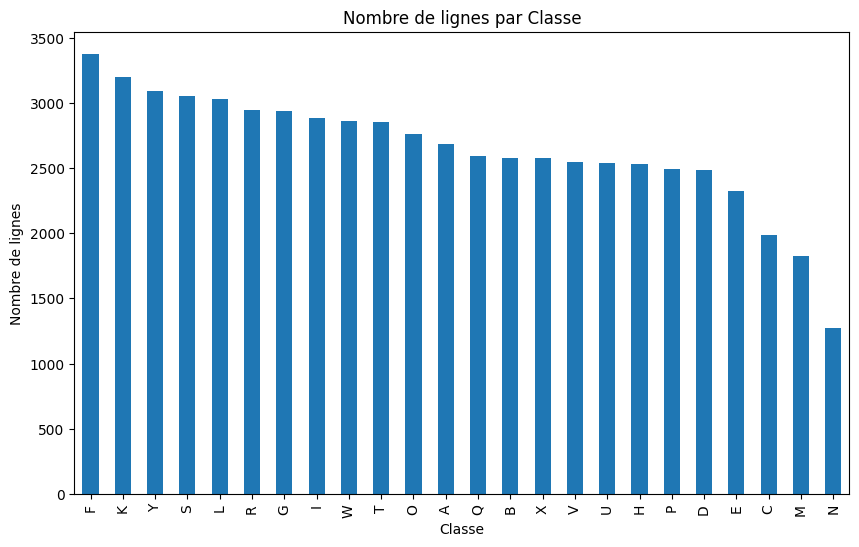

In [10]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par Classe')
plt.show()

In [11]:
seuil_bas = 1100
seuil_haut = 2500

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df['label'] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57387 entries, 0 to 57386
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      57387 non-null  object
 1   keypoints  57387 non-null  object
dtypes: object(2)
memory usage: 896.8+ KB


In [12]:
df_filtered.head(5)

,label,keypoints
0,F,"[(0.6080918312072754, 0.7958990931510925), (0...."
1,F,"[(0.5290077328681946, 0.8140897750854492), (0...."
2,F,"[(0.5758554339408875, 0.8130979537963867), (0...."
3,F,"[(0.6174376606941223, 0.8981552124023438), (0...."
4,F,"[(0.7912595272064209, 0.6377230882644653), (0...."


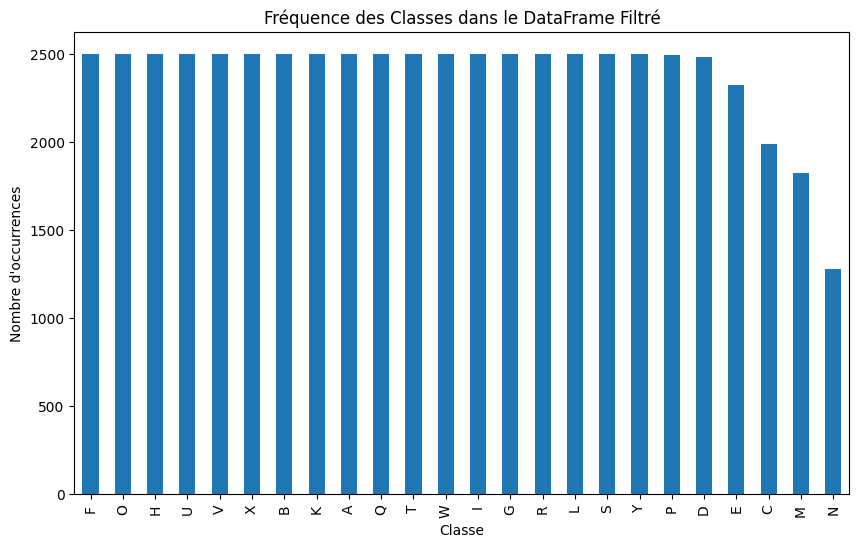

In [13]:
class_counts_filtered = df_filtered['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Fréquence des Classes dans le DataFrame Filtré')
plt.show()

In [14]:
class_counts_filtered.__len__()

24

In [15]:
def transform_tuples(row):
    keypoints = eval(row)
    return [coord for point in keypoints for coord in point]
df_filtered['keypoints'] = df_filtered['keypoints'].apply(transform_tuples)
print(df_filtered.head())
# df['keypoints'] = df['keypoints'].apply(transform_tuples)
# print(df.head())

  label                                          keypoints
0     F  [0.6080918312072754, 0.7958990931510925, 0.705...
1     F  [0.5290077328681946, 0.8140897750854492, 0.634...
2     F  [0.5758554339408875, 0.8130979537963867, 0.677...
3     F  [0.6174376606941223, 0.8981552124023438, 0.736...
4     F  [0.7912595272064209, 0.6377230882644653, 0.861...


In [16]:
X = pd.DataFrame(df_filtered['keypoints'].tolist())
y = df_filtered['label']

In [17]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.608092,0.795899,0.705809,0.680648,0.769494,0.590850,0.781183,0.484955,0.770897,0.383403,...,0.440373,0.196321,0.397408,0.550252,0.297186,0.492489,0.273850,0.426545,0.283576,0.360910
1,0.529008,0.814090,0.634031,0.697812,0.700310,0.596234,0.719700,0.485819,0.709954,0.382265,...,0.365975,0.175789,0.312787,0.551033,0.215257,0.482896,0.187497,0.414554,0.190962,0.350020
2,0.575855,0.813098,0.677082,0.688939,0.730231,0.589643,0.749444,0.477938,0.747834,0.371500,...,0.382785,0.185014,0.351475,0.550862,0.248251,0.483972,0.220472,0.414630,0.223119,0.351491
3,0.617438,0.898155,0.736615,0.798830,0.820415,0.684572,0.862465,0.568150,0.864082,0.448159,...,0.583122,0.212539,0.402521,0.561250,0.295893,0.464344,0.292593,0.383114,0.334447,0.319502
4,0.791260,0.637723,0.861714,0.534512,0.893794,0.431374,0.903395,0.332889,0.896215,0.232409,...,0.567229,0.054399,0.532326,0.371508,0.417228,0.320001,0.408429,0.245621,0.435179,0.180553


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# models = [
#     LogisticRegression(),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     SVC(),
#     KNeighborsClassifier()
# ]

# for model in models:
#     scores = cross_val_score(model, X_train, y_train, cv=5) 
#     print(f"Model: {type(model).__name__}")
#     print(f"Cross-validation scores: {scores}")
#     print(f"Mean score: {scores.mean()}")
#     print(f"Standard deviation: {scores.std()}")

KeyboardInterrupt: 

In [61]:
# model_xgb = xgb.XGBClassifier()
# label_encoder = LabelEncoder()

# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.fit_transform(y_test)

# scores = cross_val_score(model_xgb, X_train, y_train_encoded, cv=5)

# print(f"Model: {type(model_xgb).__name__}")
# print(f"Cross-validation scores: {scores}")
# print(f"Mean score: {scores.mean()}")
# print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.98375262 0.98445143 0.98602376 0.98462614 0.98707198]
Mean score: 0.9851851851851852
Standard deviation: 0.0011971936896583999


In [63]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, n_jobs=4)
# grid_search.fit(X_train, y_train_encoded)

# print("Meilleurs hyperparamètres :")
# print(grid_search.best_params_)

Meilleurs hyperparamètres :
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [64]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

In [72]:
# scores = cross_val_score(best_model, X_train, y_train_encoded, cv=5)

# print(f"Model: {type(best_model).__name__}")
# print(f"Cross-validation scores: {scores}")
# print(f"Mean score: {scores.mean()}")
# print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.98619846 0.9881202  0.9881202  0.98724668 0.9886443 ]
Mean score: 0.9876659678546471
Standard deviation: 0.0008601351240455282


In [26]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

param_grid = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model_xgb.set_params(**param_grid)
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       526
           1       1.00      1.00      1.00       507
           2       0.99      1.00      1.00       416
           3       1.00      0.99      0.99       532
           4       0.99      0.99      0.99       449
           5       1.00      1.00      1.00       498
           6       0.99      1.00      0.99       492
           7       1.00      0.99      1.00       506
           8       1.00      0.99      0.99       513
           9       1.00      1.00      1.00       517
          10       1.00      1.00      1.00       488
          11       0.97      0.98      0.98       356
          12       0.99      0.95      0.97       251
          13       0.99      1.00      0.99       474
          14       1.00      0.99      1.00       500
          15       0.99      1.00      1.00       494
          16       0.99      0.99      0.99       482

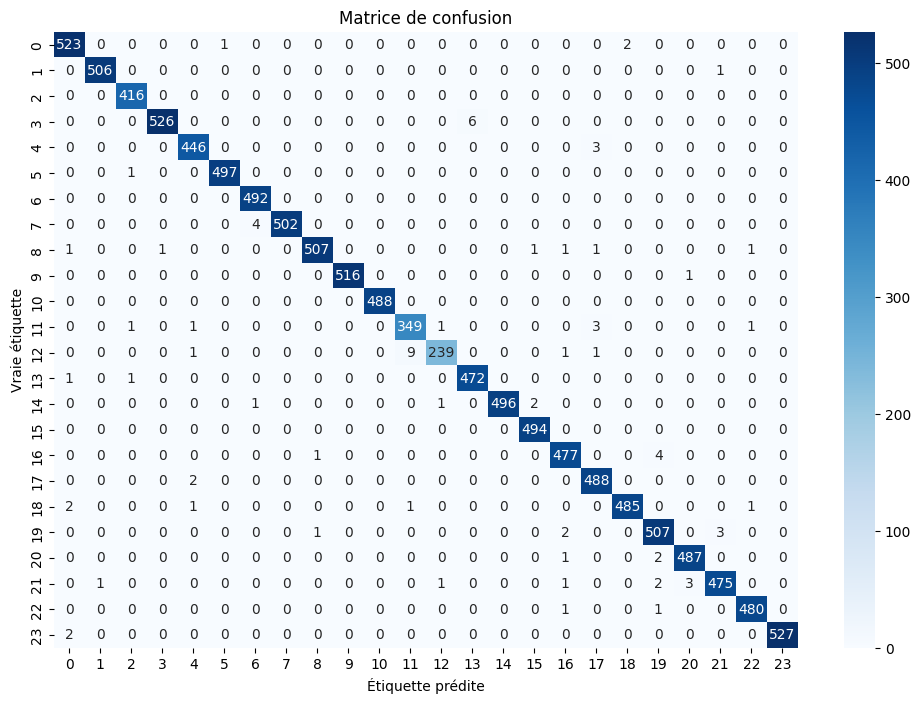

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.title('Matrice de confusion')
plt.show()

In [30]:
joblib.dump(model_xgb, 'model_xgb_v2.pkl')

['model_xgb_v2.pkl']

In [31]:
model = joblib.load('model_xgb_v2.pkl')

In [32]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [33]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands.Hands(static_image_mode=False,
                                    max_num_hands=1,
                                    min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = mp_hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
            keypoints = np.array(keypoints).flatten()
            prediction = model.predict([keypoints])
            prediction = class_names[prediction[0]]
            cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    cv2.imshow('Handpose', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()